# Introduction

.....


Check to see if jupyter lab uses the correct python interpreter with '!which python'.
It should be something like '/opt/anaconda3/envs/[environment name]/bin/python' (on Mac).
If not, try this: https://github.com/jupyter/notebook/issues/3146#issuecomment-352718675

In [2]:
!where python

C:\Users\fluhrer\AppData\Local\Continuum\anaconda3\envs\[new_env]\python.exe


# Install dependencies:

In [3]:
install_packages = True
if install_packages:
    !conda install tensorflow=2 -y
    !conda install -c anaconda pandas -y
    !conda install -c conda-forge tensorflow-hub -y
    !conda install -c akode html2text -y
    !conda install -c conda-forge tqdm -y
    !conda install -c anaconda scikit-learn -y
    !conda install -c conda-forge matplotlib -y
    !conda install -c anaconda seaborn -y

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\fluhrer\AppData\Local\Continuum\anaconda3\envs\[new_env]

  added / updated specs:
    - tensorflow=2


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _tflow_select-2.2.0        |            eigen           3 KB
    absl-py-0.11.0             |   py36haa95532_0         190 KB
    aiohttp-3.6.3              |   py36he774522_0         598 KB
    astor-0.8.1                |           py36_0          46 KB
    async-timeout-3.0.1        |           py36_0          12 KB
    blinker-1.4                |           py36_0          21 KB
    ca-certificates-2020.10.14 |                0         159 KB
    cachetools-4.1.1           |             py_0          12 KB
    click-7.1.2                |             py_0          67 KB
    google-auth-1.23.0         |     pyhd3eb1b0_0          62 KB
    goog

# Imports

In [4]:
#imports
import pandas as pd
import numpy as np
import os
import time
import tensorflow as tf
import tensorflow_hub as hub
import zipfile
from html2text import HTML2Text
from tqdm import tqdm
import re
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import seaborn as sns

# Set pandas print options
This will improve readability of printed pandas dataframe.


In [6]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## Set global Parameters
Set your parameters here:

data_path: In this path put the data you have downloaded with YouTube Data Tools. 
output_path: Tghe files generated in this notebook will be saved here.

url_dict: URLs to models on Tensorflow hub are saved here. Other models are available there.
model_type: Define which model you would like to use. Choose one from url_dict

new_embeddings: If this is true, new embeddings will be generated and saved at output_path. Otherwise, embeddings are loaded from Disc.




In [13]:
data_path = './Comments_Naomi_Seibt_Video.csv'
output_path = "./output/"

new_embeddings = True

url_dict = {
            'Transformer' : "https://tfhub.dev/google/universal-sentence-encoder-large/5",
            'DAN' : "https://tfhub.dev/google/universal-sentence-encoder/4",
            'Transformer_Multilingual': "https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3"
}

model_type = 'Transformer' #@param ['DAN','Transformer','Transformer_Multilingual']

## Create output directory
Try to create the directory defined by output_path

In [14]:
try:
   os.mkdir(output_path)
except OSError:
  print ("Creation of the directory %s failed" % output_path)
else:
  print ("Successfully created the directory %s " % output_path)


Creation of the directory ./output/ failed


# Load Data
Load you data as a pandas dataframe

In [16]:
if new_embeddings:
    data = pd.read_csv(data_path)

In [17]:
data.head()

,id,replyCount,likeCount,publishedAt,authorName,text,authorChannelId,authorChannelUrl,isReply,isReplyTo,isReplyToName
0,Ugzj7h7QCfk764_Mr0B4AaABAg,0.0,0,11/9/2020 13:34,Dietmar Wohlleben,"Naomi Seibt is paid and intensively prepared by Heartland &quot;Institute&quot;, a tobacco &amp; CO2 (coal, gas,petrol industry) lobby group, which she places with severall extreme right-wing and Russian television stations for interviews. See <a href=""https://en.wikipedia.org/wiki/The_Heartland_Institute"">https://en.wikipedia.org/wiki/The_Heartland_Institute</a><br />Seibt is also a member of the right-wing extremist organization &quot;Junge Alternative&quot; , which the German Office for the Protection of the Constitution considers unconstitutional.",UCob91BXmALLUXRiU2lFKS3g,http://www.youtube.com/channel/UCob91BXmALLUXRiU2lFKS3g,0,NaN,NaN
1,UgxkXtx7wZU2JiS0PnF4AaABAg,0.0,0,11/1/2020 8:03,Rene van Westen,"Both Naomi and Greta are amazing young woman. OK, Greta is more agressive in her speech. At <a href=""https://www.youtube.com/watch?v=9zrHs3dv7LQ&amp;t=3m39s"">3:39</a>, humans have no contribution: Well, not the way most think. But just by being here on this earth with 7.5 bil people, yeah off course we contribute for a part. But as arrogant as we are, we dont want to see that.",UCadhBYRRHqbaivLiDgRjB1w,http://www.youtube.com/channel/UCadhBYRRHqbaivLiDgRjB1w,0,NaN,NaN
2,UgzZaWoFwz-nLVoiPk14AaABAg,0.0,0,10/30/2020 19:49,Henni,Wenn du mündliche Prüfung in englisch hast,UC5vjT61J5dQoX4ajdS6RioA,http://www.youtube.com/channel/UC5vjT61J5dQoX4ajdS6RioA,0,NaN,NaN
3,UgyiD5a5yV6C9w36uEh4AaABAg,0.0,0,10/29/2020 17:18,cameron zero,Wow 2019 so many years of experience and scientific knowledge,UCUr8euGA8EI0gVSxGn-0Yug,http://www.youtube.com/channel/UCUr8euGA8EI0gVSxGn-0Yug,0,NaN,NaN
4,UgwDwZJCHwK_vdMF2ox4AaABAg,0.0,0,10/29/2020 9:12,Dave Clarke,"Why so many dislikes? Nothing Naomi said was that offensive to the intellect, surely.",UCyVI9JGHzD6Mc4mgzaaRDng,http://www.youtube.com/channel/UCyVI9JGHzD6Mc4mgzaaRDng,0,NaN,NaN


# Preprocessing
Preprocess your data:
- Drop empty rows
- Drop unused columns

In [18]:
if new_embeddings:
    data = data.dropna(subset=['text', 'authorName']) # drop rows with no content
    data=data.drop(['id', 'replyCount','likeCount','authorChannelUrl','authorChannelId','isReplyTo','isReplyToName'],axis=1) # drop unused columns
    data.head()

- remove HTML-tags, links and usernames

In [19]:
if new_embeddings:
    # Remove HTML tags
    tqdm.pandas()
    h = HTML2Text()
    h.ignore_links = True
    data['cleaned'] = data['text'].progress_apply(lambda x: h.handle(x))
    print( "Removed HTML Tags.")

    # Remove links
    http_link_pattern = r'http\S+'
    bitly_link_pattern = r'bit.ly/\S+'
    data['cleaned'] = data['cleaned'].str.replace(http_link_pattern, '')
    data['cleaned'] = data['cleaned'].str.replace(bitly_link_pattern, '')
    print( "Removed Links.")

100%|████████████████████████████████████████████████████████████████████████████| 1592/1592 [00:00<00:00, 6386.54it/s]

Removed HTML Tags.
Removed Links.


# Save or Load preprocessed data

Save your data afte preprocessing, or load preprocessed data from disc.

In [20]:
if new_embeddings:
  data.to_pickle(output_path+'data_preprocessed'+'.pkl')
else:
  data = pd.read_pickle(output_path+'data_preprocessed'+'.pkl')
data.head()

,publishedAt,authorName,text,isReply,cleaned
0,11/9/2020 13:34,Dietmar Wohlleben,"Naomi Seibt is paid and intensively prepared by Heartland &quot;Institute&quot;, a tobacco &amp; CO2 (coal, gas,petrol industry) lobby group, which she places with severall extreme right-wing and Russian television stations for interviews. See <a href=""https://en.wikipedia.org/wiki/The_Heartland_Institute"">https://en.wikipedia.org/wiki/The_Heartland_Institute</a><br />Seibt is also a member of the right-wing extremist organization &quot;Junge Alternative&quot; , which the German Office for the Protection of the Constitution considers unconstitutional.",0,"Naomi Seibt is paid and intensively prepared by Heartland ""Institute"", a\ntobacco & CO2 (coal, gas,petrol industry) lobby group, which she places with\nseverall extreme right-wing and Russian television stations for interviews.\nSee \nSeibt is also a member of the right-wing extremist organization ""Junge\nAlternative"" , which the German Office for the Protection of the Constitution\nconsiders unconstitutional.\n\n"
1,11/1/2020 8:03,Rene van Westen,"Both Naomi and Greta are amazing young woman. OK, Greta is more agressive in her speech. At <a href=""https://www.youtube.com/watch?v=9zrHs3dv7LQ&amp;t=3m39s"">3:39</a>, humans have no contribution: Well, not the way most think. But just by being here on this earth with 7.5 bil people, yeah off course we contribute for a part. But as arrogant as we are, we dont want to see that.",0,"Both Naomi and Greta are amazing young woman. OK, Greta is more agressive in\nher speech. At 3:39, humans have no contribution: Well, not the way most\nthink. But just by being here on this earth with 7.5 bil people, yeah off\ncourse we contribute for a part. But as arrogant as we are, we dont want to\nsee that.\n\n"
2,10/30/2020 19:49,Henni,Wenn du mündliche Prüfung in englisch hast,0,Wenn du mündliche Prüfung in englisch hast\n\n
3,10/29/2020 17:18,cameron zero,Wow 2019 so many years of experience and scientific knowledge,0,Wow 2019 so many years of experience and scientific knowledge\n\n
4,10/29/2020 9:12,Dave Clarke,"Why so many dislikes? Nothing Naomi said was that offensive to the intellect, surely.",0,"Why so many dislikes? Nothing Naomi said was that offensive to the intellect,\nsurely.\n\n"


# Produce Text Embeddings with Universal Sentence Encoder

## Load Model
Load the model from TF-hub

In [21]:
hub_url = url_dict[model_type]
if new_embeddings:
  print("Loading model. This will take some time...")
  embed = hub.load(hub_url)

Loading model. This will take some time...


## Embed Documents
Produce embeddings of your documents.

In [22]:
if new_embeddings:
    for k,g in data.groupby(np.arange(len(data))//200):
        if k == 0:
            embeddings = embed(g['cleaned'])
        else:
            embeddings_new = embed(g['cleaned'])
            embeddings = tf.concat(values=[embeddings,embeddings_new],axis = 0)
            print(k , end =" ")
    print("The embeddings vector is of fixed length {}".format(embeddings.shape[1]))

    np.save(output_path+'/embeddings'+model_type+'.npy', embeddings, allow_pickle=True, fix_imports=True)
else:
    embeddings = np.load(output_path+'/embeddings'+model_type+'.npy', mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')

embeddings.shape

1 2 3 4 5 6 7 The embeddings vector is of fixed length 512


TensorShape([1592, 512])

## Calculate Similarity Matrix with angular distance

'Following Cer et al. (2018), we first compute
the sentence embeddings u, v for an STS sentence
pair, and then score the sentence pair similarity
based on the angular distance between the two
embedding vectors  d = − arccos (uv/||u|| ||v||).'

In [23]:
from sklearn.metrics.pairwise import cosine_similarity
def cos_sim(input_vectors):
    similarity = cosine_similarity(input_vectors)
    return similarity
cosine_similarity_matrix = cos_sim(np.array(embeddings))
print(cosine_similarity_matrix)

[[ 1.          0.4433955   0.05505778 ...  0.01702606  0.3150363
  -0.00370582]
 [ 0.4433955   0.9999998   0.01497677 ...  0.03613643  0.17931402
  -0.01068806]
 [ 0.05505778  0.01497677  1.0000002  ...  0.08898681  0.0761539
   0.07409675]
 ...
 [ 0.01702606  0.03613643  0.08898681 ...  0.9999999   0.13675542
   0.24166256]
 [ 0.3150363   0.17931402  0.0761539  ...  0.13675542  0.9999999
   0.06460285]
 [-0.00370582 -0.01068806  0.07409675 ...  0.24166256  0.06460285
   1.        ]]


# Plots Similarity 
Plot and print a heat map showing the semantic contextual similarity between comments.

C:\Users\fluhrer\AppData\Local\Continuum\anaconda3\envs\[new_env]\lib\site-packages\seaborn\matrix.py:311: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
C:\Users\fluhrer\AppData\Local\Continuum\anaconda3\envs\[new_env]\lib\site-packages\seaborn\matrix.py:311: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


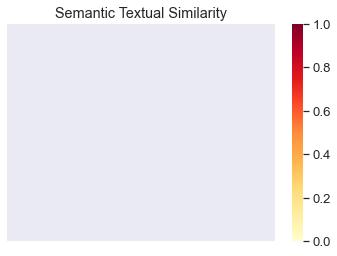

In [24]:
import seaborn as sns
def plot_similarity(labels, features, rotation):
  corr = np.inner(features, features)
  sns.set(font_scale=1.2)
  g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labels, rotation=rotation)
  g.set_title("Semantic Textual Similarity")

num_samples = 5
off_set = 10000

plot_similarity(data.iloc[off_set:off_set+num_samples]['cleaned'], embeddings[off_set:off_set+num_samples], 90)

# Show neighbours of a comment 
Define which comment to analyze

In [39]:
comment_index = 221
comment = data["cleaned"][comment_index]
comment_list = data["cleaned"].tolist()
print(comment)

Many of you talk about scientists...most of them are sold to big
companies...they took huge amount of money if they support climate change
propaganda...if they have different opinion they dont get anything....this is
the reality..wake up




Print similar comments.

In [40]:
def get_top_similar(sentence, sentence_list, similarity_matrix, topN):
    # find the index of sentence in list
    index = sentence_list.index(sentence)
    # get the corresponding row in similarity matrix
    similarity_row = np.array(similarity_matrix[index, :])
    # get the indices of top similar
    indices = similarity_row.argsort()[-topN:][::-1]
    return [sentence_list[i] for i in indices]


for i, value in enumerate(get_top_similar(comment, comment_list, cosine_similarity_matrix, 10)):
  print("Top similar comment {}: {}".format(i+1, value))

Top similar comment 1: Many of you talk about scientists...most of them are sold to big
companies...they took huge amount of money if they support climate change
propaganda...if they have different opinion they dont get anything....this is
the reality..wake up


Top similar comment 2: She is supported by heartland institute which gets 40% of it's funding from
ExxonMobil. If course they are trying to convince people that climate change
isn't serious, as it would ruin their business.


Top similar comment 3: This is what happens when people begin thinking for themselves and research
beyond the leftist echo chamber. They discover the real science and realise
they have been lied to about man made climate change.


Top similar comment 4: Anyone unsure about Climate Change go and watch Potholer54's channel, he knows
his stuff. Unlike these idiots in the video.


Top similar comment 5: Remember folks the people who are shouting about "Man made climate change" are
the same people who tell you 